# Importing libraries

In [14]:
import os
import sys
sys.path.insert(0, os.path.join(os.path.dirname(
    os.path.abspath('./data')), ".."))

import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

import numpy as np
from pylab import plt
%matplotlib inline

import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

# Importing data

In [21]:
df = pd.read_parquet(
    '/home/quangbinh/code/Group23_Business_Analytics/data/processed/1d', 
    # dtype={'timestamp': str}
)
# df['timestamp'] = pd.to_datetime(df['timestamp'].str.slice(0, 10))
df.set_index('timestamp', inplace=True)
df.sort_index(ascending=True, inplace=True)
df

,open,close,high,low,volume
timestamp,,,,,
1997-05-15 13:30:00,0.121875,0.097917,0.125000,0.096354,1443120000
1997-05-16 13:30:00,0.098438,0.086458,0.098958,0.085417,294000000
1997-05-19 13:30:00,0.088021,0.085417,0.088542,0.081250,122136000
1997-05-20 13:30:00,0.086458,0.081771,0.087500,0.081771,109344000
1997-05-21 13:30:00,0.081771,0.071354,0.082292,0.068750,377064000
...,...,...,...,...,...
2023-12-29 14:30:00,153.100006,151.940002,153.889999,151.029999,39789000
2024-01-02 14:30:00,151.539993,149.929993,152.380005,148.389999,47339400
2024-01-03 14:30:00,149.199997,148.470001,151.050003,148.330002,49425500


In [22]:
df.dtypes

open      float64
close     float64
high      float64
low       float64
volume      int64
dtype: object

# Exploratory data analysis

## Trends

<AxesSubplot:title={'center':'HPG Closing Price'}, xlabel='timestamp'>

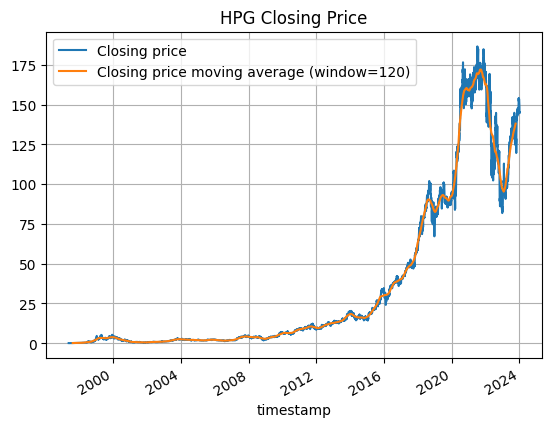

In [24]:
df['close'].rename('Closing price').plot(title='HPG Closing Price', grid=True, legend=True)
df['close'].rolling(120, center=True).mean().rename('Closing price moving average (window=120)').plot(grid=True, legend=True)

<AxesSubplot:title={'center':'HPG Trading Volume'}, xlabel='timestamp'>

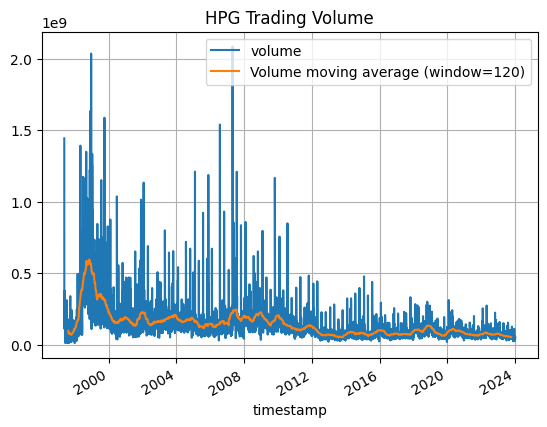

In [25]:
df['volume'].plot(title='HPG Trading Volume', grid=True, legend=True)
df['volume'].rolling(120, center=True).mean().rename('Volume moving average (window=120)').plot(grid=True, legend=True)

## Seasonality

Text(0.5, 1.0, 'HPG Closing Price Lag Plot (lag=1)')

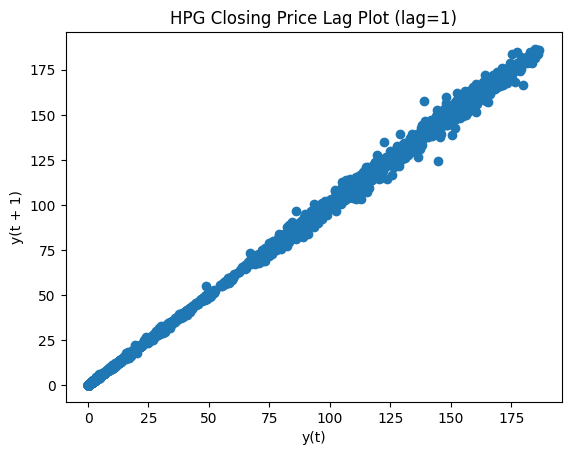

In [26]:
pd.plotting.lag_plot(df['close'], lag=1).set_title('HPG Closing Price Lag Plot (lag=1)')

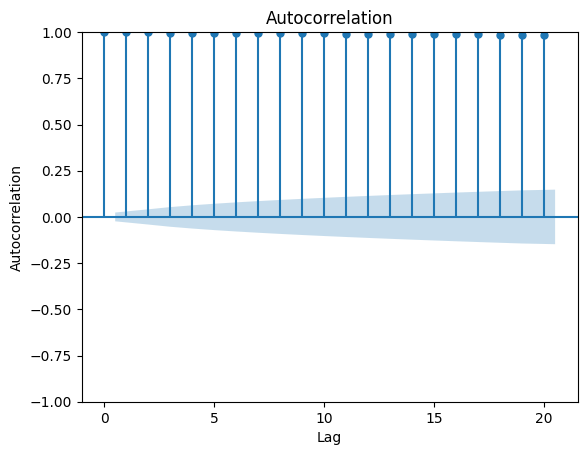

/home/quangbinh/code/Group23_Business_Analytics/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


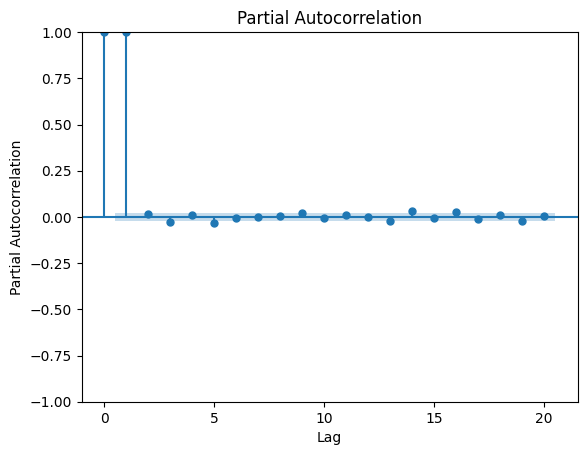

In [27]:
# Plot the ACF
plot_acf(df['close'], lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot the PACF
plot_pacf(df['close'], lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

# Predicting closing prices with LSTM

## Data preprocessing

### Removing redundant columns

In [28]:
df = df[['close']]

### Scaling

In [29]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df['close'] = scaler.fit_transform(df['close'].values.reshape(-1,1))
df

/tmp/ipykernel_10033/1772904015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['close'] = scaler.fit_transform(df['close'].values.reshape(-1,1))


,close
timestamp,
1997-05-15 13:30:00,-0.999698
1997-05-16 13:30:00,-0.999821
1997-05-19 13:30:00,-0.999832
1997-05-20 13:30:00,-0.999872
1997-05-21 13:30:00,-0.999983
...,...
2023-12-29 14:30:00,0.628629
2024-01-02 14:30:00,0.607074
2024-01-03 14:30:00,0.591417


### Loading

In [30]:
from typing import Tuple

def load_data(
        stock: pd.DataFrame,
        look_back: int,
        test_from_date: str
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    
    stock = stock.sort_index(ascending=True, axis=0)
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    
    # Find the index corresponding to the test_from_date
    test_from_date = pd.to_datetime(test_from_date)
    test_start_index = np.where(stock.index >= test_from_date)[0][0] - look_back
    # print(test_start_index, len(data))
    
    x_train = data[:test_start_index,:-1,:]
    y_train = data[:test_start_index,-1,:]
    
    x_test = data[test_start_index:,:-1]
    y_test = data[test_start_index:,-1,:]
    
    return x_train, y_train, x_test, y_test

In [31]:
look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df, look_back, '2023-10-01')

# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

print('x_train.shape = ',x_train.size())
print('y_train.shape = ',y_train.size())
print('x_test.shape = ',x_test.size())
print('y_test.shape = ',y_test.size())

x_train.shape =  torch.Size([6650, 59, 1])
y_train.shape =  torch.Size([6650, 1])
x_test.shape =  torch.Size([68, 59, 1])
y_test.shape =  torch.Size([68, 1])


## Model definition

In [32]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [33]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


## Model training

In [34]:
loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [35]:
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch", t, " MSE:", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch 10  MSE: 0.09491831064224243
Epoch 20  MSE: 0.023189276456832886
Epoch 30  MSE: 0.012347659096121788
Epoch 40  MSE: 0.004628872033208609
Epoch 50  MSE: 0.0025402591563761234
Epoch 60  MSE: 0.0011430202284827828
Epoch 70  MSE: 0.0007399457390420139
Epoch 80  MSE: 0.0005590427317656577
Epoch 90  MSE: 0.000517250329721719


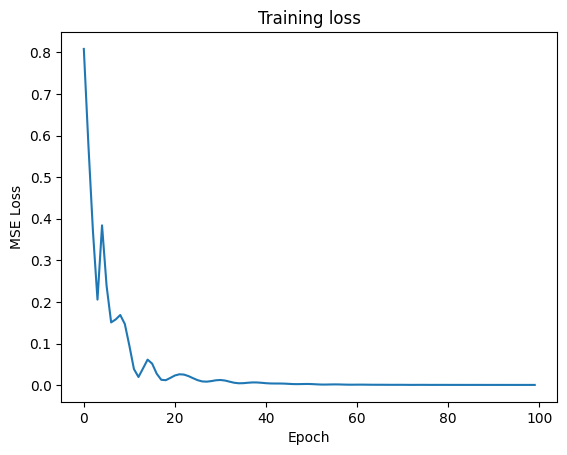

In [36]:
plt.plot(hist)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

## Model testing

In [37]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.05 RMSE
Test Score: 3.89 RMSE


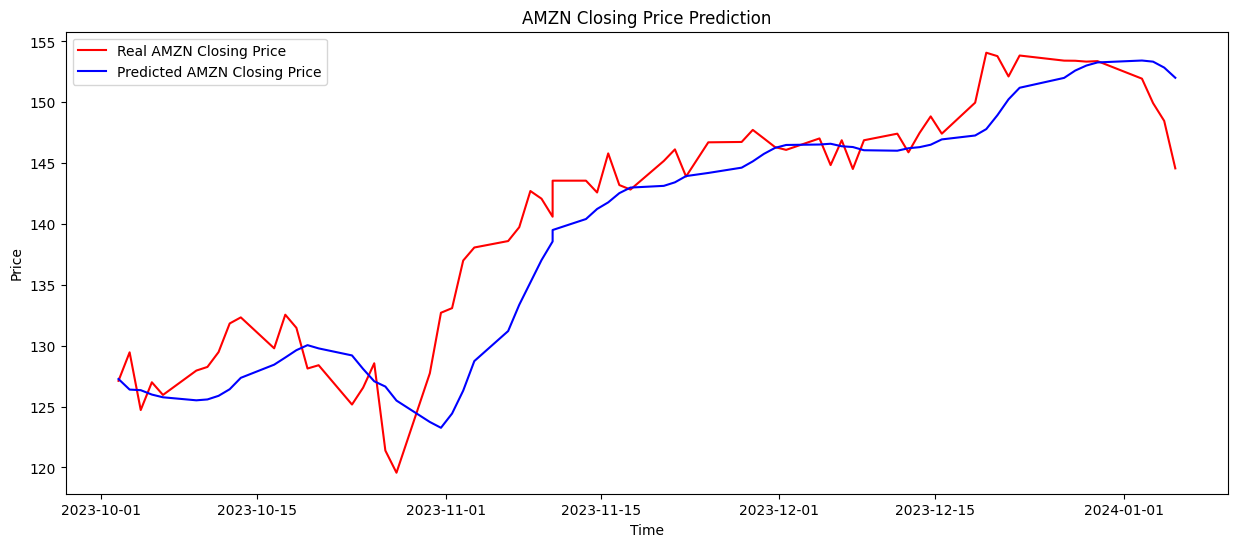

In [42]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(np.array(df[len(df)-len(y_test):].index), y_test, color = 'red', label = 'Real AMZN Closing Price')
axes.plot(np.array(df[len(df)-len(y_test):].index), y_test_pred, color = 'blue', label = 'Predicted AMZN Closing Price')
plt.title('AMZN Closing Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Reference

https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch